# Flight Causal Inference

In this notebook we use both the granger and the pcmci methods for causality. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm
import seaborn as sns

In [2]:
df = pd.read_csv("data/666200402020631.csv")
df = df.drop(columns=[df.columns[0]])
df.head()

,VAR_2670,VAR_5107,VAR_6670,FPAC,BLAC,CTAC,TH,MH,EGT_1,EGT_2,...,ATEN,LATP,FIRE_1,FIRE_2,FIRE_3,FIRE_4,FGC3,ILSF,ESN_1,ESN_2
0,1465.0,2632.0,3513.0,0.000006,0.001960,-0.000023,-28.488613,-24.507687,79.034841,78.934205,...,-5.199093e-17,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
1,1465.0,2632.0,3513.0,-0.000007,0.002785,0.000023,-49.740381,-42.089356,6.751757,6.722887,...,-2.599547e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
2,1465.0,2632.0,3513.0,0.000007,0.003202,-0.000023,-43.547730,-37.325465,27.224032,27.257060,...,-1.733031e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
3,1465.0,2632.0,3513.0,-0.000007,0.002608,0.000023,-47.318559,-40.029642,15.059799,15.043408,...,-1.386425e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0
4,1465.0,2632.0,3513.0,0.000007,0.003288,-0.000023,-44.565684,-38.190090,23.850340,23.755760,...,-1.391841e-16,41.410048,0.0,0.0,0.0,0.0,120.0,100.0,7889.0,7805.0


We define the area of the time series of interest. 

In [3]:
df_flight= df.iloc[650:900]
i_variable= "ROLL"

We know proceed with making the variables stationary. We will only do 1st and 2nd order differences. 

In [4]:
from statsmodels.tsa.stattools import adfuller
# make signals stationary

df_stationary = df_flight.diff().dropna()
print(df_stationary.shape)

df_stationary2 = df_stationary.copy()

second_order = []

for column in df_stationary2:
    adf_test = adfuller(df_stationary2[column])
    if adf_test[1]>0.05:
        df_stationary2[column] = df_stationary2[column].diff().dropna()
        second_order.append(column)


        
df_stationary2 = df_stationary2.dropna()        
# remove columns that with all values 0
df_stationary2 = df_stationary2.loc[:, (df_stationary2 != 0).any(axis=0)]
print(df_stationary2.shape)
# remove columns with std less than 1e-9
df_stationary2 = df_stationary2.loc[:, (abs(df_stationary2.std(axis = 0))>1e-9)]
print(df_stationary2.shape)
    
df_stationary2.head()

(249, 185)


C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= 

(248, 167)
(248, 131)


,FPAC,BLAC,CTAC,TH,MH,EGT_1,EGT_2,EGT_3,EGT_4,IVV,...,ECYC_3,ECYC_4,EHRS_1,DWPT,EHRS_4,EHRS_3,EHRS_2,TMODE,LATP,FGC3
652,0.000590,-0.000670,-0.000468,0.010532,-0.162335,1.703144,-0.011967,2.142893,0.744993,-1.466391,...,0.006662,-0.005666,0.001328,-1.091394e-11,0.000546,0.001142,0.001328,-4.440892e-16,-2.131628e-14,7.105427e-14
653,-0.000606,0.000833,0.000477,-0.264132,-0.091285,1.945671,0.065298,2.292328,-0.174767,3.207314,...,0.006824,-0.005852,0.001325,0.000000e+00,0.000544,0.001139,0.001325,-4.440892e-16,1.421085e-14,0.000000e+00
654,0.000623,-0.001006,-0.000487,-0.019475,-0.192275,1.255911,-0.633975,2.858405,0.946849,-0.891056,...,0.002946,-0.002561,0.000546,-1.091394e-11,0.000223,0.000470,0.000546,1.332268e-15,1.723253e-04,7.105427e-14
655,-0.000641,0.000920,0.000497,-0.321860,-0.150493,0.767534,-0.573927,1.245657,0.407799,2.049583,...,-0.002775,0.002364,-0.000550,1.091394e-11,-0.000226,-0.000473,-0.000550,0.000000e+00,-1.723253e-04,-1.421085e-14
656,0.000660,-0.000947,-0.000507,-0.124977,-0.296276,0.274944,0.804243,1.013427,1.135991,-0.626633,...,-0.006995,0.006048,-0.001321,1.091394e-11,-0.000541,-0.001136,-0.001321,-4.440892e-16,7.105427e-15,-5.684342e-14


We can now see that the variables are now stationary

Text(0.5, 1.0, 'SPL_1')

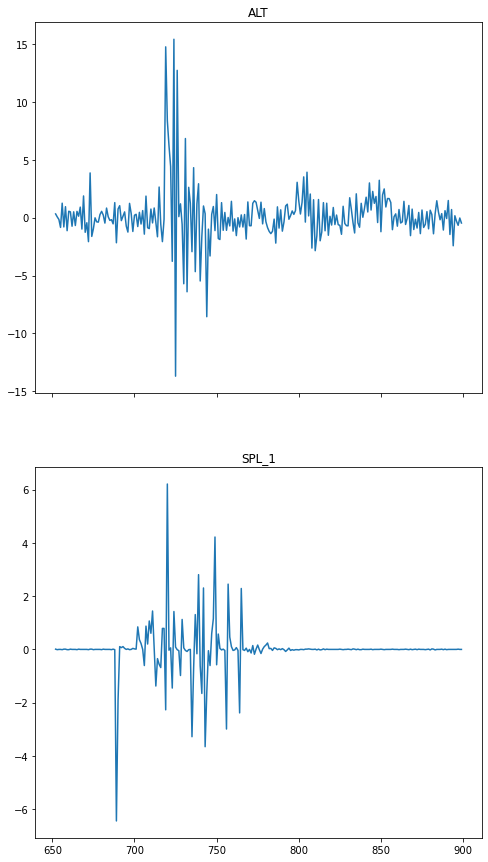

In [5]:
fig, axs = plt.subplots(2, sharex=True,figsize=(8,15)) #, sharey=True
axs[0].plot(df_stationary2.index, df_stationary2["ALT"])
axs[0].set_title("ALT")
axs[1].plot(df_stationary2.index, df_stationary2["SPL_1"])
axs[1].set_title("SPL_1")


In [6]:
# Grangers causation matrix

'''maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in matrix.columns:
        for r in matrix.index:
            test_result= grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values= [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            matrix.loc[r,c] = min_p_value
    matrix.columns = [var + '_x' for var in variables]
    matrix.index = [var + '_y' for var in variables]
    return matrix
        

grangers_causation_matrix(df_stationary2, variables = df_stationary2.columns)
'''
# 

"maxlag=12\ntest = 'ssr_chi2test'\ndef grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):\n    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)\n    for c in matrix.columns:\n        for r in matrix.index:\n            test_result= grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)\n            p_values= [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]\n            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')\n            min_p_value = np.min(p_values)\n            matrix.loc[r,c] = min_p_value\n    matrix.columns = [var + '_x' for var in variables]\n    matrix.index = [var + '_y' for var in variables]\n    return matrix\n        \n\ngrangers_causation_matrix(df_stationary2, variables = df_stationary2.columns)\n"

Grangers causation test is run to reduce the number of variables of interest to our multivariate problem.

In [7]:
# Grangers causation test 

maxlag=5
test = 'ssr_chi2test'
i_variables = [i_variable]

for column in df_stationary2.columns:
    if column != i_variable:
        test_result= grangercausalitytests(df_stationary2[[i_variable, column]], maxlag=maxlag, verbose=False)
        p_values= [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        min_p_value = np.min(p_values)
        if min_p_value<0.00001:
            i_variables.append(column)

len(i_variables)

C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 3
  'rank is %d' % (J, J_), ValueWarning)
C:\Users\Ander\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\base\model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 5, but rank is 4
  'rank is %d' % (J,

17

Based on the reduced number of variables we run the PCMCI tests. 

In [8]:
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.independence_tests import ParCorr, CMIknn, GPDC
from tigramite.pcmci import PCMCI

df_multivariate = df_stationary2[i_variables]
data = df_multivariate.to_numpy()
var_names= df_multivariate.columns
df_causal = pp.DataFrame(data, var_names=var_names)

Could not import rpy package
Could not import r-package RCIT


In [9]:
parcorr = ParCorr(significance='analytic')
gpdc = GPDC(significance='analytic', gp_params=None)
pcmci = PCMCI(
    dataframe=df_causal,
    cond_ind_test=parcorr,
    verbosity=0)

In [10]:
results = pcmci.run_pcmci(tau_max=16, pc_alpha=0.05)

In [11]:
q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], fdr_method='fdr_bh')


In [12]:
link_matrix = pcmci.return_significant_parents(pq_matrix=q_matrix,
                        val_matrix=results['val_matrix'], alpha_level=0.01)['link_matrix']

In [13]:
deleted_variables = []
i=0
var_names=list(var_names)
position_var = var_names.index(i_variable)

print(position_var)
for variable in link_matrix:
    if ((True not in variable[position_var,:]) & (i !=position_var)):
        deleted_variables.append(i)
    i+=1

i_link_matrix = np.delete(np.delete(link_matrix, deleted_variables, axis=0),deleted_variables, axis=1)
print(i_link_matrix.shape, link_matrix.shape)
i_val_matrix = np.delete(np.delete(results['val_matrix'], deleted_variables, axis=0), deleted_variables, axis=1)
print(i_val_matrix.shape, results['val_matrix'].shape)
i_var_names= np.delete(var_names, deleted_variables, axis=0)
print(i_var_names)

0
(16, 16, 17) (17, 17, 17)
(16, 16, 17) (17, 17, 17)
['ROLL' 'CTAC' 'WD' 'AOA1' 'PH' 'LGDN' 'AOAI' 'AOAC' 'AIL_1' 'AIL_2'
 'SPL_1' 'SPL_2' 'ECYC_1' 'ECYC_2' 'ECYC_3' 'ECYC_4']


In [14]:
i_position_var = list(i_var_names).index(i_variable)

for row in range(i_link_matrix.shape[1]):
    for array in range(i_link_matrix.shape[0]):
        if row != i_position_var:
            i_link_matrix[array][row]=False
            

<IPython.core.display.Javascript object>


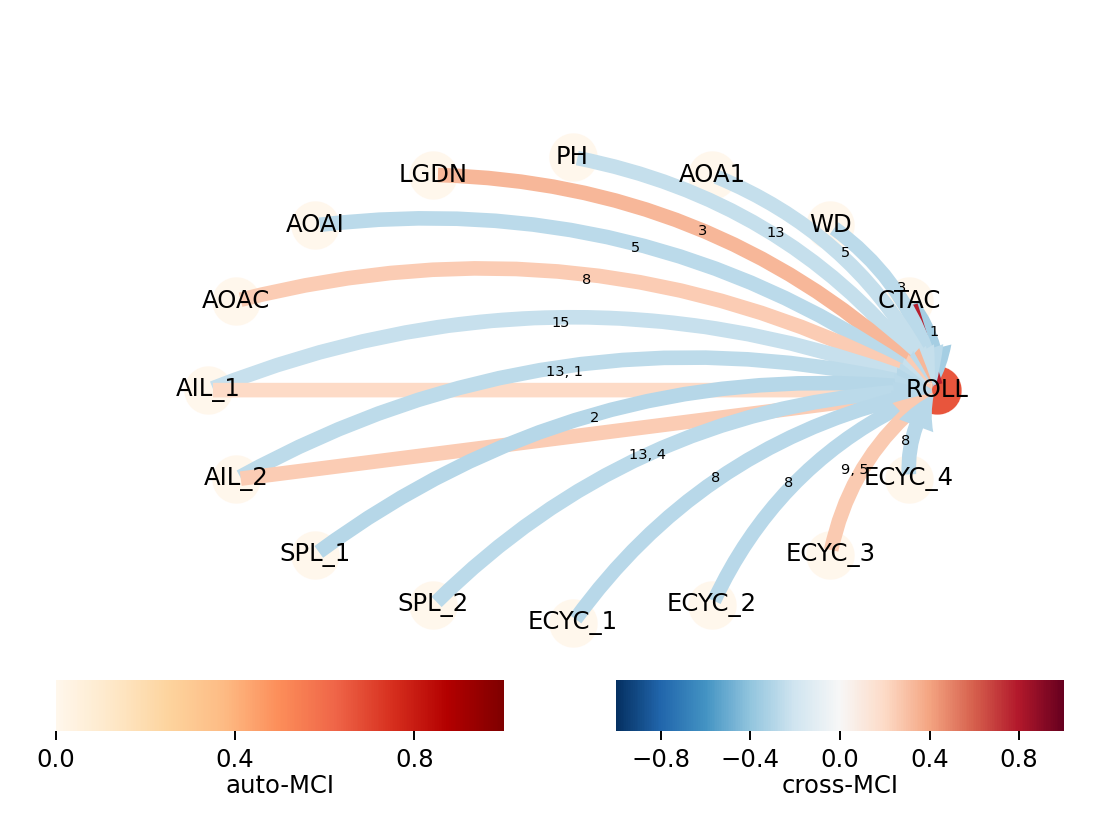

(<Figure size 640x480 with 3 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a561584648>)

In [15]:
%matplotlib notebook
tp.plot_graph(
    val_matrix=i_val_matrix,
    link_matrix=i_link_matrix,
    var_names=i_var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    )

<IPython.core.display.Javascript object>


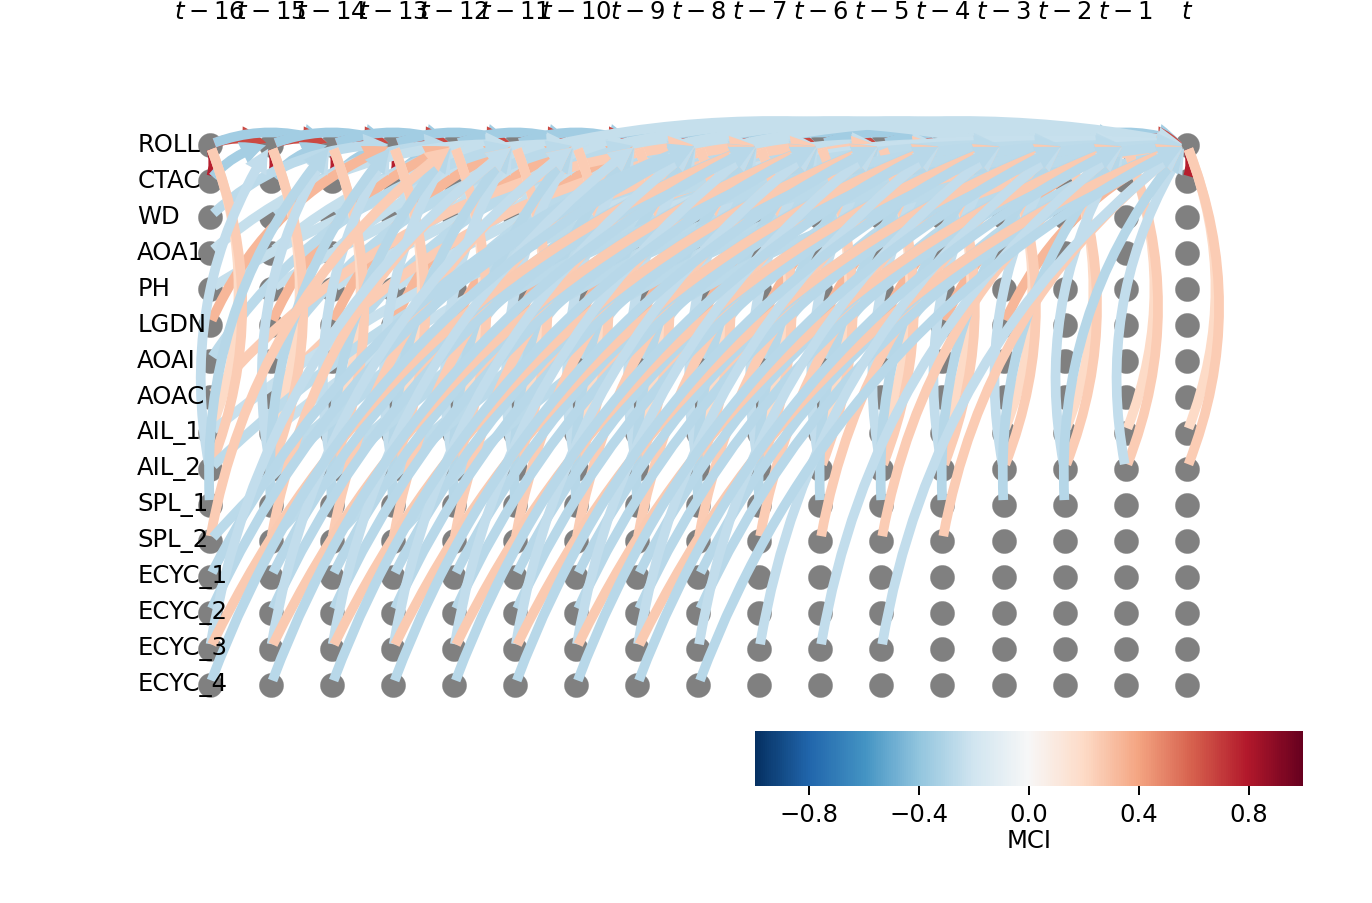

In [16]:
tp.plot_time_series_graph(
    val_matrix=i_val_matrix,
    link_matrix=i_link_matrix,
    var_names=i_var_names,
    link_colorbar_label='MCI',
    )

<IPython.core.display.Javascript object>


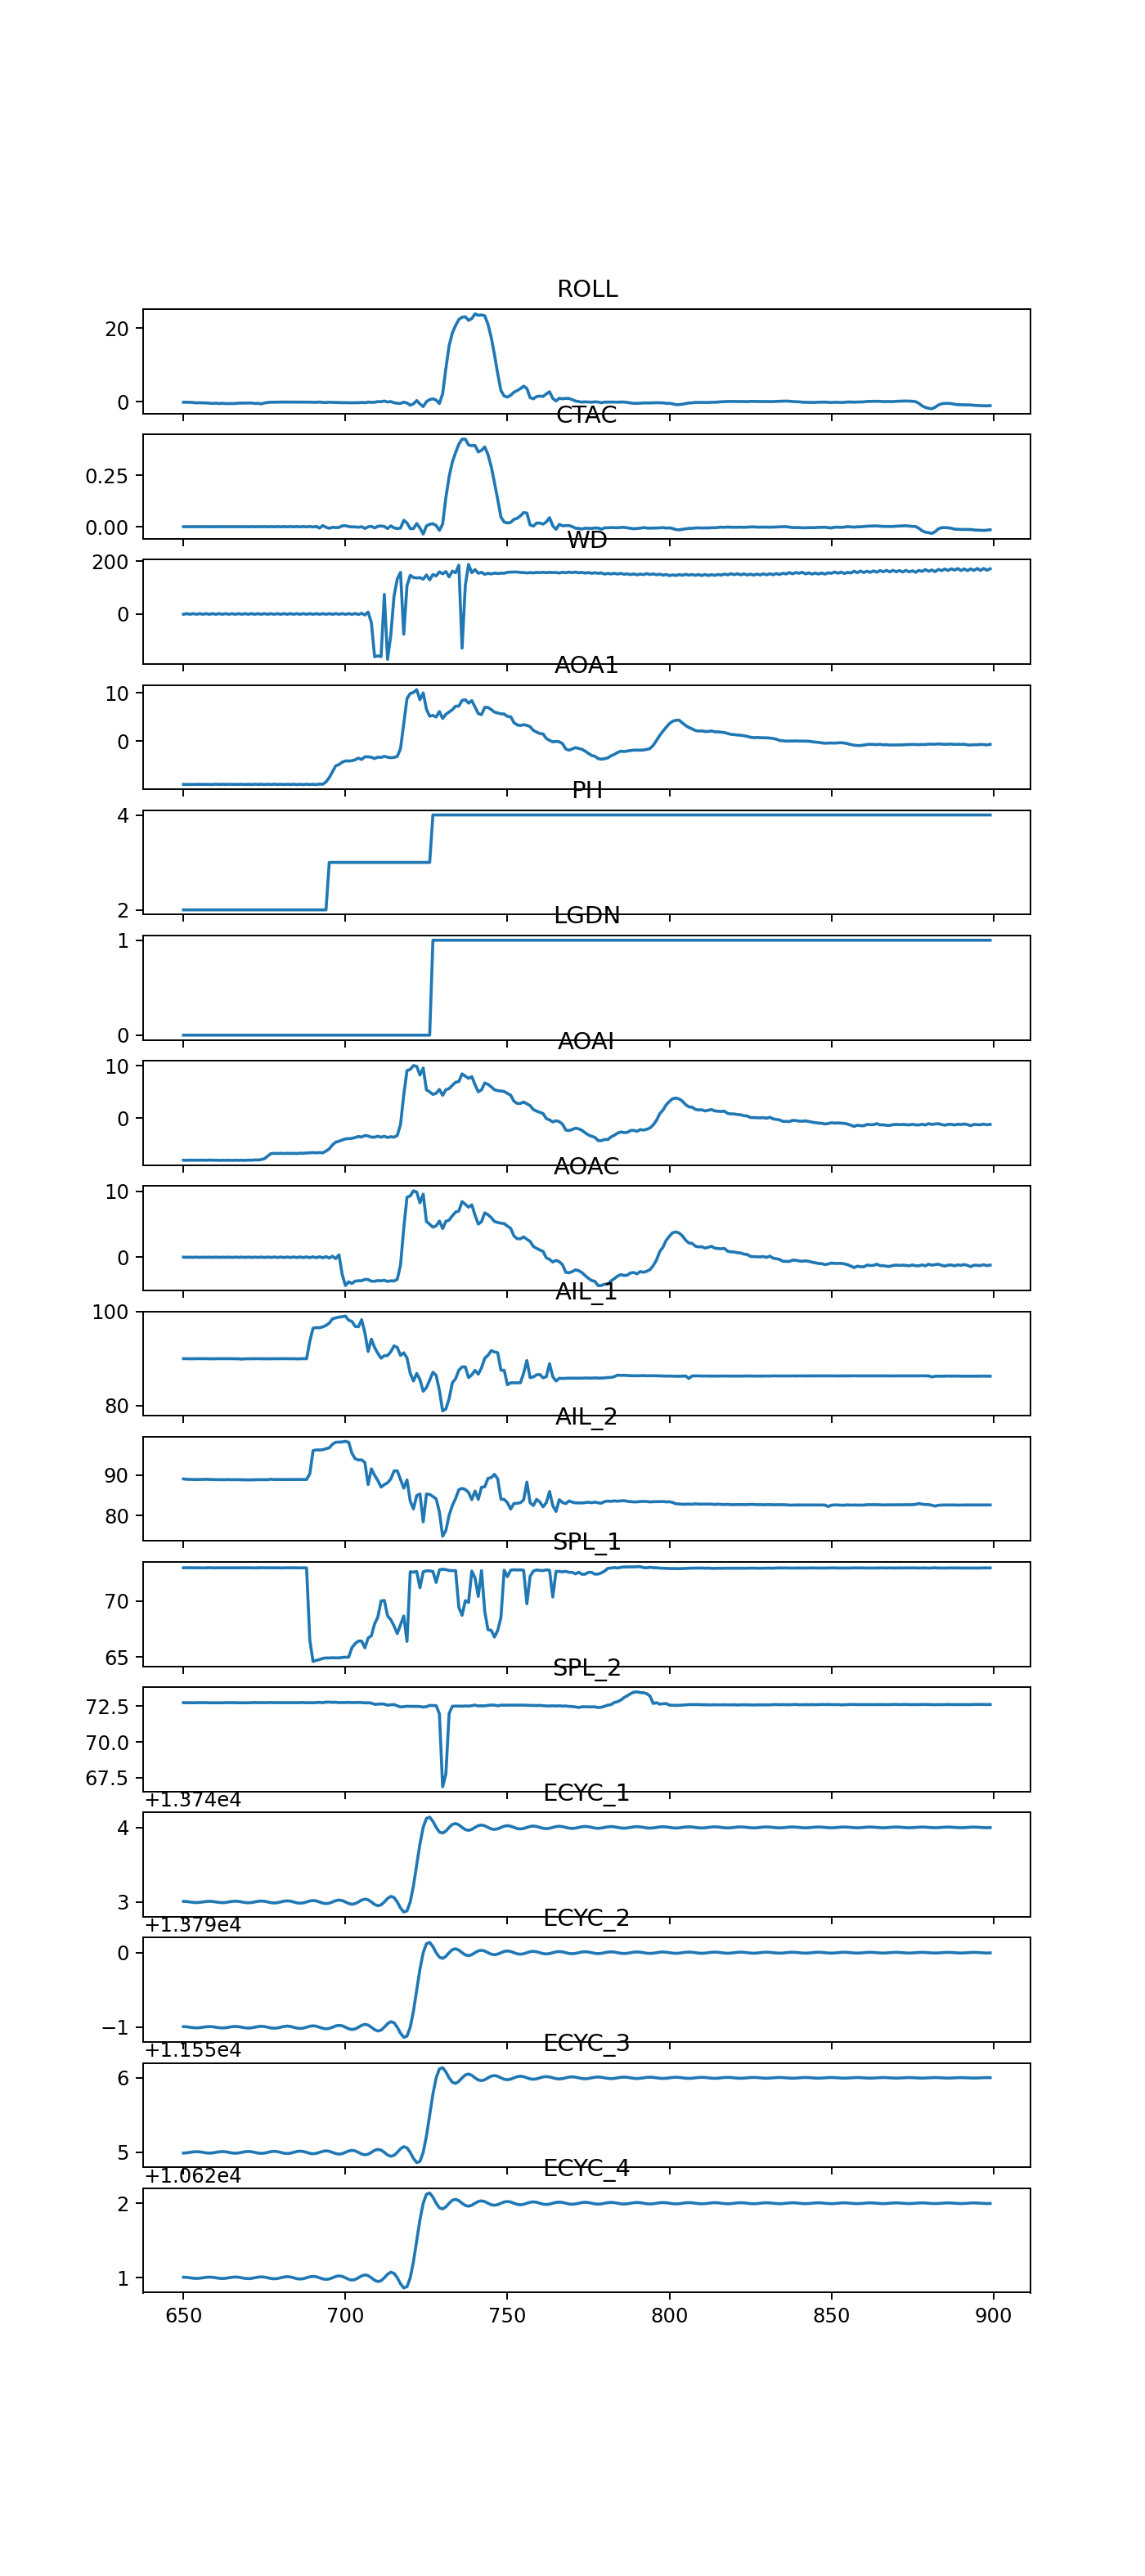

In [17]:
i_var_names

fig, axs = plt.subplots(len(i_var_names), sharex=True,figsize=(8,18)) #, sharey=True

for name in i_var_names:
    index = list(i_var_names).index(name)
    axs[index].plot(df_flight.index, df_flight[name])
    axs[index].set_title(name)
    